In [ ]:
Project title: Analysis for Sweet Lift Taxi Company 

# Project description

Sweet Lift Taxi company has collected historical data on taxi orders at airports. To attract more drivers during peak hours, we need to predict the amount of taxi orders for the next hour. Build a model for such a prediction.

The RMSE metric on the test set should not be more than 48.

## Project instructions

1. Download the data and resample it by one hour.
2. Analyze the data.
3. Train different models with different hyperparameters. The test sample should be 10% of the initial dataset. 
4. Test the data using the test sample and provide a conclusion.

## Data description

The data is stored in file `taxi.csv`. The number of orders is in the '*num_orders*' column.

## Preparation

In [1]:
#Import libraries 
import pandas as pd 
import numpy as np 
import time 

import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.utils import shuffle 
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error 
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import TimeSeriesSplit

from xgboost import XGBRegressor 
from lightgbm import LGBMRegressor 
from catboost import CatBoostRegressor 

from statsmodels.tsa.seasonal import seasonal_decompose 

import warnings 
warnings.filterwarnings('ignore')

In [2]:
#Download dataset 
data = pd.read_csv('/datasets/taxi.csv', 
                  index_col = [0],
                  parse_dates = [0])

In [3]:
#Organize data based on datetime 
data.sort_index(inplace=True)
data.index.is_monotonic

True

In [4]:
#Data general info
data.info()
data.describe()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
#Checking for missing values 
data.isna().sum()

num_orders    0
dtype: int64

In [6]:
#Reviewing data 
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [7]:
#Reviewing data 
data.tail()

,num_orders
datetime,
2018-08-31 23:10:00,32
2018-08-31 23:20:00,24
2018-08-31 23:30:00,27
2018-08-31 23:40:00,39
2018-08-31 23:50:00,53


<AxesSubplot:xlabel='datetime'>

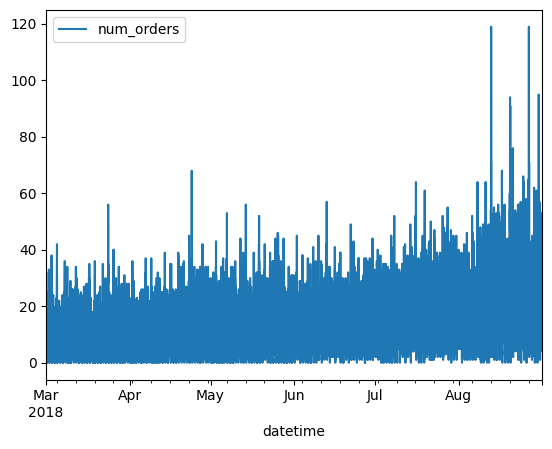

In [8]:
#Examining data for trends & seasonality 
data.plot()

Description: In examining the data it becomes clear data resampling needs to be completed as no trends or seasonality is present. 

In [9]:
#Resample by 1 hour 
data_hour = data.resample('1H').sum()
data_day = data.resample('1D').sum()

In [10]:
#Time Features 

data_hour['month'] = data_hour.index.month 
data_hour ['day'] = data_hour.index.day 
data_hour ['day_of_week'] = data_hour.index.dayofweek 
data_hour ['hour'] = data_hour.index.hour 

In [11]:
#Lag features 
data_hour['lag1'] = data_hour ['num_orders'].shift(1)
data_hour['lag2'] = data_hour ['num_orders'].shift(2)
data_hour['lag3'] = data_hour ['num_orders'].shift(3)

In [12]:
#Rolling features 
data_hour['rolling_mean_null']=data_hour['num_orders'].shift().rolling(2).mean()
data_hour['rolling_mean']=data_hour['num_orders'].shift().rolling(2, min_periods=1).mean()
data_hour['rolling_sum']=data_hour['num_orders'].shift().rolling(2, min_periods=1).sum()

In [13]:
#Expanding features 
data_hour['expanding_mean']=data_hour['num_orders'].shift().expanding(2).mean()
data_hour['expanding_sum']=data_hour['num_orders'].shift().expanding(2).sum()

Description: Data has been reviewed, resampled, and feature engineering has been performed. Next steps will be to analyze the data for trends and devise seasonal graphs to determine which features align with the target. 

## Analysis

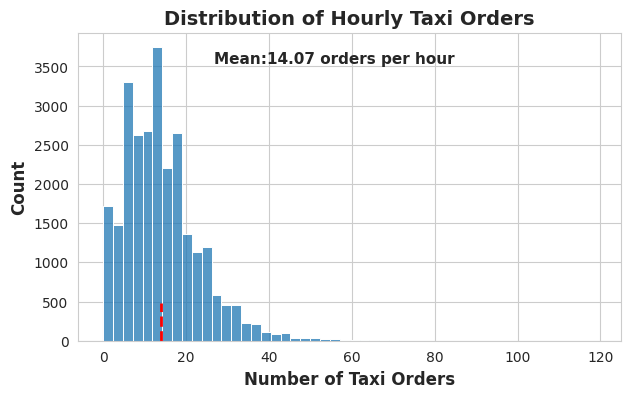

In [14]:
#Plot histogram to show distribution of hourly taxi orders 
sns.set_style('whitegrid')
plt.figure(figsize=(7,4))

sns.histplot(data['num_orders'], bins=50)
plt.title('Distribution of Hourly Taxi Orders', fontsize=14, fontweight='bold')
plt.xlabel('Number of Taxi Orders',fontsize=12, fontweight='bold')
plt.ylabel('Count',fontsize=12, fontweight='bold')
hour_mean = data['num_orders'].mean()
plt.vlines(x=hour_mean, ymin=0, ymax=480, colors='red',ls='--',lw=2)
plt.text(0.25,0.9,f'Mean:{hour_mean:0.2f} orders per hour',transform=plt.gca().transAxes, fontsize=11, fontweight='bold')
plt.show()


Description: The hourly taxi orders is shown to have a negative skewed distribution. The data is more clustered towards the higher end of the range. 

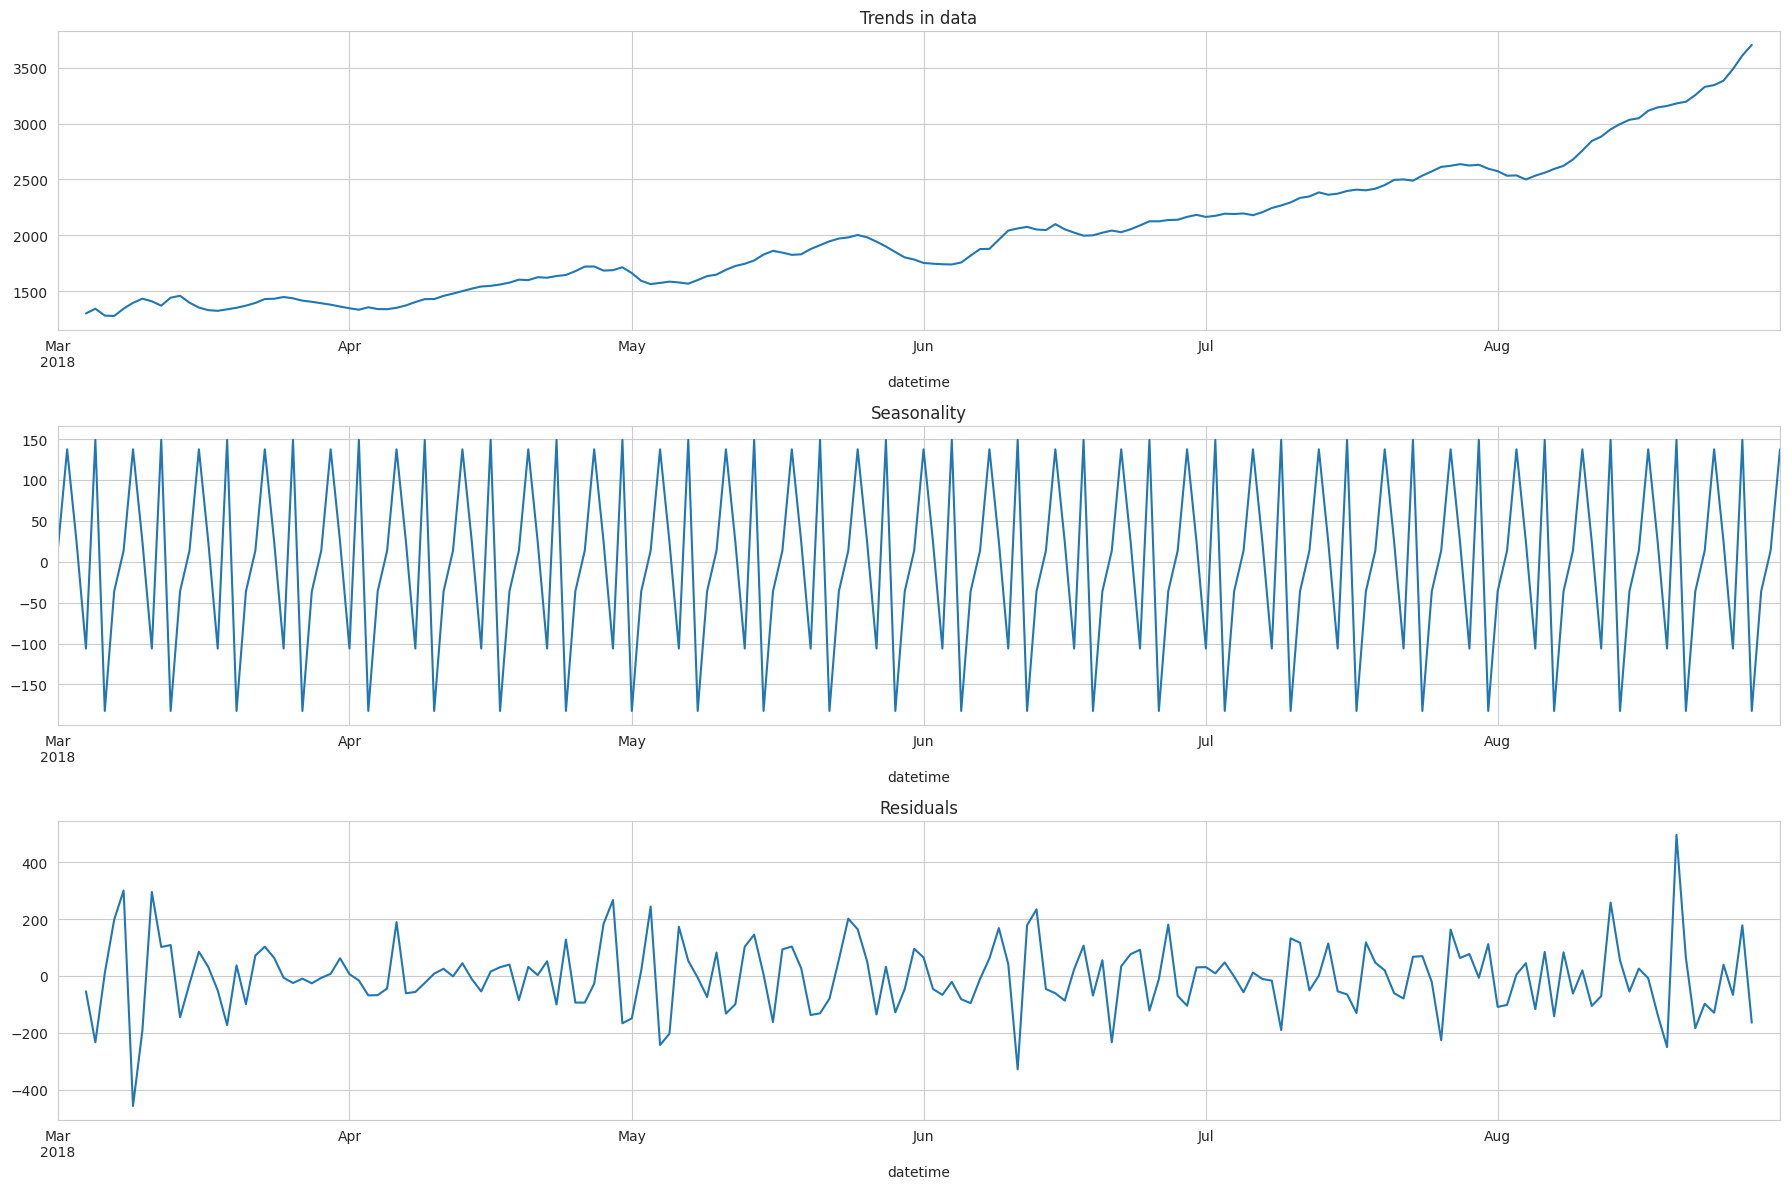

In [15]:
#Examine trends and seasonal data from full dataset 

decomposed = seasonal_decompose(data_day['num_orders'])

plt.figure(figsize=(18,12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trends in data')
plt.subplot(312)
decomposed.seasonal.plot(ax = plt.gca())
plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax = plt.gca())
plt.title('Residuals')
plt.tight_layout()

Description: The need for taxis increased from March to August as seen in the visual. There were daily fluctuations as observed in the visual. 

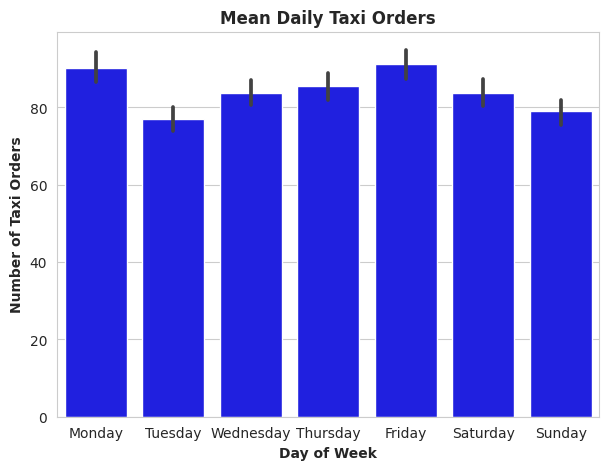

In [16]:
# Barchart to show the mean daily taxi orders from March to August 
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))

sns.barplot(data=data_hour, x = 'day_of_week', y= 'num_orders', color='blue')
plt.title('Mean Daily Taxi Orders', fontsize=12, fontweight='bold')
plt.xlabel('Day of Week', fontsize=10, fontweight='bold')
plt.ylabel('Number of Taxi Orders',fontsize=10, fontweight='bold')

day_of_week_labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
plt.xticks(np.arange(7),day_of_week_labels)
plt.show()

Description: The most popular days of the week for taxi orders is Monday and Friday. The difference though is not signficant. 

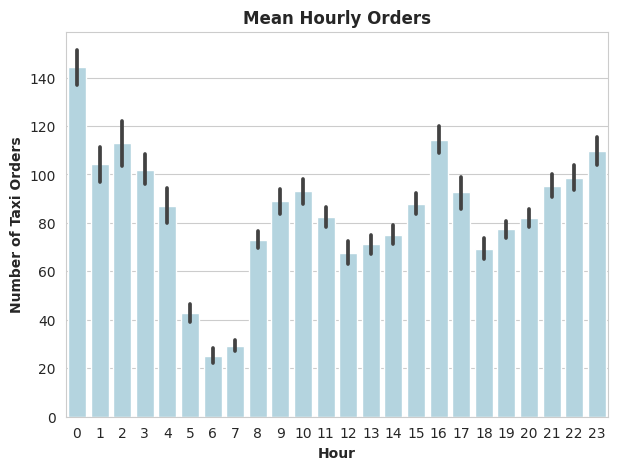

In [17]:
#Barchart to show the overall mean hourly taxi orders 
sns.set_style('whitegrid')
plt.figure(figsize=(7,5))

sns.barplot(data=data_hour, x = 'hour', y= 'num_orders', color='lightblue')
plt.title('Mean Hourly Orders',fontsize=12, fontweight='bold') 
plt.xlabel('Hour', fontsize=10, fontweight='bold')
plt.ylabel('Number of Taxi Orders',fontsize=10, fontweight='bold')

plt.show()

Description: The peak hours for taxi hours are 0000 hours and 1600 hours. This makes sense as 0000 hours aligns with peak socializing hours after work and 1600 aligns with a typical workday. Whereas 0600 and 0700 hours would be times when the majority of travelers would be asleep. 

In [18]:
#Visual for hourly taxi orders for each day of the week 
hourly_orders_by_week_day = data_hour.pivot_table(
    index = 'day_of_week',
    columns= 'hour',
    values = 'num_orders',
    aggfunc = 'mean'
)
hourly_orders_by_week_day

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
day_of_week,,,,,,,,,,,,,,,,,,,,,
0,168.576923,135.923077,149.076923,118.269231,104.423077,49.423077,25.423077,30.192308,75.038462,96.192308,...,74.230769,97.884615,107.884615,92.576923,67.153846,79.000000,65.384615,86.653846,90.230769,94.000000
1,119.538462,98.961538,88.230769,94.884615,73.038462,37.346154,23.192308,35.653846,67.769231,80.230769,...,70.307692,85.076923,101.884615,88.307692,69.153846,74.307692,72.961538,90.538462,77.923077,109.461538
2,137.538462,81.653846,107.615385,91.576923,82.192308,40.423077,35.000000,31.423077,74.846154,87.576923,...,79.500000,79.769231,119.307692,90.307692,64.115385,90.846154,93.192308,102.038462,93.923077,112.230769
3,147.074074,101.037037,121.814815,116.037037,92.888889,41.037037,14.444444,26.111111,75.259259,94.555556,...,64.037037,82.851852,121.296296,103.333333,71.407407,62.555556,81.962963,99.444444,93.000000,113.148148
4,145.666667,96.925926,112.740741,83.333333,84.444444,36.666667,31.592593,30.703704,75.555556,93.407407,...,77.555556,77.407407,117.592593,106.444444,86.814815,80.222222,103.333333,113.222222,146.296296,117.370370
5,169.884615,133.000000,124.115385,109.038462,90.000000,49.461538,25.961538,26.961538,77.115385,95.730769,...,76.346154,98.923077,113.038462,75.846154,62.307692,78.076923,75.076923,80.346154,84.576923,96.307692
6,122.384615,83.461538,87.576923,101.192308,81.230769,44.346154,20.769231,23.923077,65.576923,73.730769,...,84.500000,94.307692,117.615385,91.307692,63.807692,76.807692,80.269231,93.384615,101.923077,125.423077


In [19]:
#Creating correlation variable 
corr = data_hour.corr()

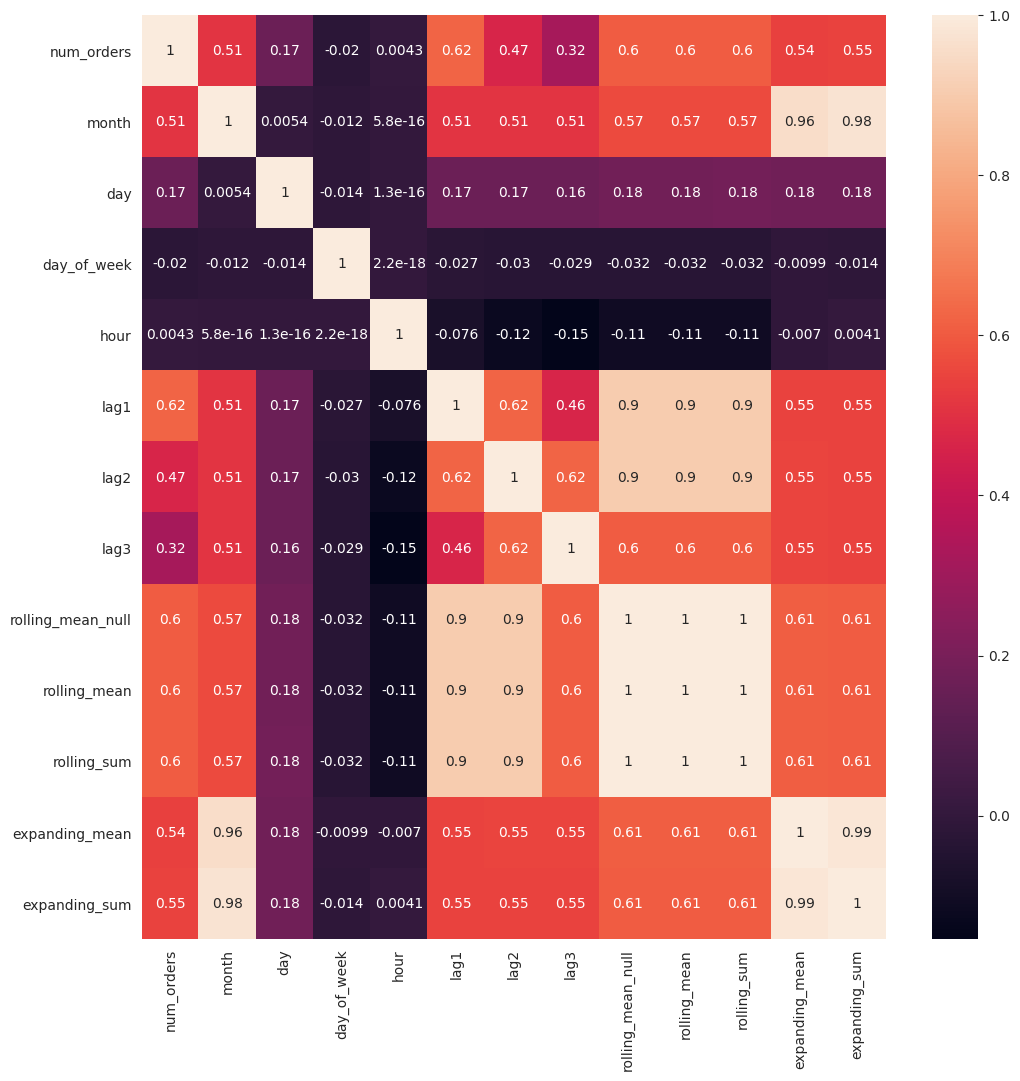

In [20]:
#Create heatmap to see correlation 
plt.figure(figsize = (12,12))
sns.heatmap(corr, annot=True)
plt.show()

Description: In examining the visual above it can be observed that the month, day, and day of week columns have an insignficant correlation to the target column. 

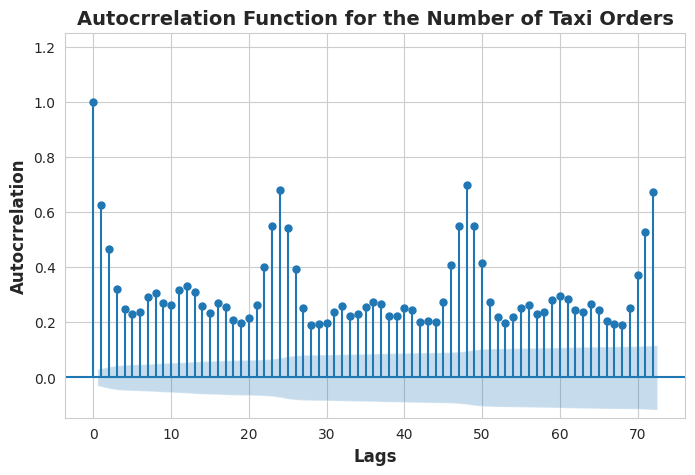

In [21]:
#Autocorrelation plot 
plt.figure(figsize=(8,5))

plot_acf(data_hour['num_orders'],lags=72, auto_ylims=True, ax=plt.gca())

plt.title('Autocrrelation Function for the Number of Taxi Orders',fontsize=14, fontweight='bold')
plt.xlabel('Lags',fontsize=12,fontweight='bold')
plt.ylabel('Autocrrelation',fontsize=12,fontweight='bold')

plt.show()

Description: In examining the autocorrelation a daily seasonal pattern emerges as spikes at lags 0,24,48 and 72 emerge.

In [22]:
#Drop unknown/missing data
data_hour = data_hour.dropna()

Description: Missing values dropped prior to training data to prevent inaccurarcies. 

## Training

In [23]:
#Defining features and target 
features = data_hour.drop(['num_orders'],axis = 1)
target = data_hour['num_orders']

In [24]:
#Spliting data into 2 datasets and setting test sample to be 10% of initial dataset 
features_train, features_test, target_train, target_test = train_test_split(features, target, shuffle = False, test_size = 0.1, random_state =12345)

In [25]:
#Data validation 
display(features_train.shape)
display(features_test.shape) 
display(target_train.shape) 
display(target_test.shape) 

(3971, 12)

(442, 12)

(3971,)

(442,)

In [26]:
#Scaling data for increased performance of models 
feature_names = ['lag1','lag2','lag3','rolling_mean_null','rolling_mean','rolling_sum','expanding_mean','expanding_sum']
transformer_mas = StandardScaler().fit(features_train [feature_names].to_numpy())

features_train_scaled = features_train.copy()
features_train_scaled.loc[:,feature_names]=transformer_mas.transform(features_train[feature_names].to_numpy())
features_test_scaled = features_test.copy()
features_test_scaled.loc[:,feature_names] = transformer_mas.transform(features_test[feature_names].to_numpy())

In [27]:
#Training RandomForest Model 
model_rf = RandomForestRegressor(random_state = 12345)
model_rf.fit(features_train_scaled, target_train)
predictions_valid_rf = model_rf.predict(features_test_scaled)

rf_rmse = (mean_squared_error(target_test, predictions_valid_rf))**0.5 
print('Random Forest RMSE:',rf_rmse)


Random Forest RMSE: 46.8912426893362


In [28]:
#Hyperparameters tuning for Random Forest

param_grid = {'n_estimators':[100,150,200],
             'max_depth':[3,5,10],
             'max_features':['sqrt','log2']
}

rf = RandomForestRegressor(random_state = 12345)

grid = GridSearchCV(estimator = rf,
                   param_grid = param_grid,
                   cv = TimeSeriesSplit(n_splits=5), 
                   scoring='neg_root_mean_squared_error')
grid.fit(features_train_scaled, target_train)
predictions_valid = grid.predict(features_test_scaled)
rf_params_rmse = (mean_squared_error(target_test, predictions_valid))**0.5 

print("The best parameters are %s with a score of %0.2f"%(grid.best_params_,grid.best_score_))
print("Random Forest RMSE with hyperparameter tuning:",rf_params_rmse)

The best parameters are {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 100} with a score of -27.66
Random Forest RMSE with hyperparameter tuning: 48.44921328335515


In [29]:
#Training LGBM

model_lgbm = LGBMRegressor(random_state=12345)
model_lgbm.fit(features_train_scaled, target_train)
predictions_valid_lgbm = model_lgbm.predict(features_test_scaled)

lgbm_rmse = (mean_squared_error(target_test, predictions_valid_lgbm))**0.5
print("LightGBM RMSE:",lgbm_rmse)

LightGBM RMSE: 41.08364009606346


In [30]:
#Hyperparameter tuning for LGBM 

param_grid = {'n_estimators':[50,100,150],
             'max_depth':[3,5,10],
             'learning_rate':[0.1,0.1]
}
lgbm = LGBMRegressor(random_state = 12345)

grid = GridSearchCV(estimator = lgbm, 
                   param_grid = param_grid, 
                   cv = TimeSeriesSplit(n_splits=5), scoring='neg_root_mean_squared_error')
grid.fit(features_train_scaled, target_train)
predictions_valid = grid.predict(features_test_scaled)
lgbm_params_rmse=(mean_squared_error(target_test, predictions_valid))**0.5

print("The best parameters are %s with a score %0.2f"% (grid.best_params_,grid.best_score_))
print("LightGBM RMSE:",lgbm_params_rmse)

The best parameters are {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 50} with a score -24.84
LightGBM RMSE: 41.89403729994483


In [31]:
#Catboost 
model_cat = CatBoostRegressor(random_state=12345)
model_cat.fit(features_train_scaled, target_train, verbose=100)
predictions_valid_cat = model_cat.predict(features_test_scaled)

cat_rmse = (mean_squared_error(target_test, predictions_valid_cat))**0.5

print("Catboost RMSE:",cat_rmse)

Learning rate set to 0.05091
0:	learn: 37.7614637	total: 47.4ms	remaining: 47.4s
100:	learn: 22.4779816	total: 160ms	remaining: 1.43s
200:	learn: 20.2265449	total: 269ms	remaining: 1.07s
300:	learn: 18.6681215	total: 376ms	remaining: 874ms
400:	learn: 17.5771119	total: 485ms	remaining: 725ms
500:	learn: 16.6367431	total: 597ms	remaining: 594ms
600:	learn: 15.8253666	total: 709ms	remaining: 471ms
700:	learn: 15.1041720	total: 820ms	remaining: 350ms
800:	learn: 14.4941965	total: 927ms	remaining: 230ms
900:	learn: 13.9276447	total: 1.04s	remaining: 114ms
999:	learn: 13.4217893	total: 1.14s	remaining: 0us
Catboost RMSE: 44.2304547593775


In [32]:
#Hyperparameter tuning for catboost 

param_grid = {'iterations':[100,150,200],
             'depth':[3,5,10],
             'learning_rate':[0.1,0.01]
}

cat = CatBoostRegressor(random_state=12345)

grid = GridSearchCV(estimator = cat,
                   param_grid = param_grid,
                   cv = TimeSeriesSplit(n_splits=5), scoring ='neg_root_mean_squared_error')

grid.fit(features_train_scaled,target_train, verbose =50)
predictions_valid = grid.predict(features_test_scaled)
cat_params_rmse = (mean_squared_error(target_test, predictions_valid))**0.5 

print("The best parameters are %s with a score %0.2f"% (grid.best_params_,grid.best_score_))
print("CatBoost RMSE:",cat_params_rmse)



0:	learn: 28.2069777	total: 387us	remaining: 38.4ms
50:	learn: 18.0106491	total: 10.7ms	remaining: 10.2ms
99:	learn: 16.3759773	total: 20.6ms	remaining: 0us
0:	learn: 29.3598277	total: 417us	remaining: 41.3ms
50:	learn: 20.0571659	total: 16.5ms	remaining: 15.8ms
99:	learn: 18.1191990	total: 35.2ms	remaining: 0us
0:	learn: 30.7852508	total: 652us	remaining: 64.6ms
50:	learn: 20.9955597	total: 23.7ms	remaining: 22.7ms
99:	learn: 19.0762192	total: 45.9ms	remaining: 0us
0:	learn: 32.1694071	total: 626us	remaining: 62ms
50:	learn: 22.0868434	total: 20ms	remaining: 19.3ms
99:	learn: 20.3231093	total: 39ms	remaining: 0us
0:	learn: 33.5696601	total: 645us	remaining: 63.9ms
50:	learn: 22.4312367	total: 23.6ms	remaining: 22.7ms
99:	learn: 20.8672771	total: 45.4ms	remaining: 0us
0:	learn: 29.4356863	total: 350us	remaining: 34.7ms
50:	learn: 24.9159195	total: 10.9ms	remaining: 10.5ms
99:	learn: 22.4672634	total: 21.8ms	remaining: 0us
0:	learn: 30.2157689	total: 443us	remaining: 44ms
50:	learn: 26.

In [33]:
#Visual of results 
visual = pd.DataFrame(
    {'Model RMSE':[rf_params_rmse,lgbm_params_rmse,cat_params_rmse],
     'Model':['RandomForest', 'LightGBM','CatBoost']}
)
visual 

,Model RMSE,Model
0,48.449213,RandomForest
1,41.894037,LightGBM
2,45.456496,CatBoost


Description: In examining the 3 models, LightGBM has the lowest RMSE value at 41.9. Therefore, the LightGBM model will be used in the testing phase.  

## Testing

In [34]:
#Train new LightGBM model using turned hyperparameters 
model_lgbm = LGBMRegressor(n_estimators=50,
                                max_depth = 10,
                                learning_rate=0.1,
                                random_state =12345)
model_lgbm.fit(features_train_scaled, target_train)
predictions_valid_lgbm= model_lgbm.predict(features_test_scaled)

lgbm_rmse_test = (mean_squared_error(target_test,predictions_valid_rf))**0.5
print("LGBM RMSE:",lgbm_rmse_test)

LGBM RMSE: 46.8912426893362


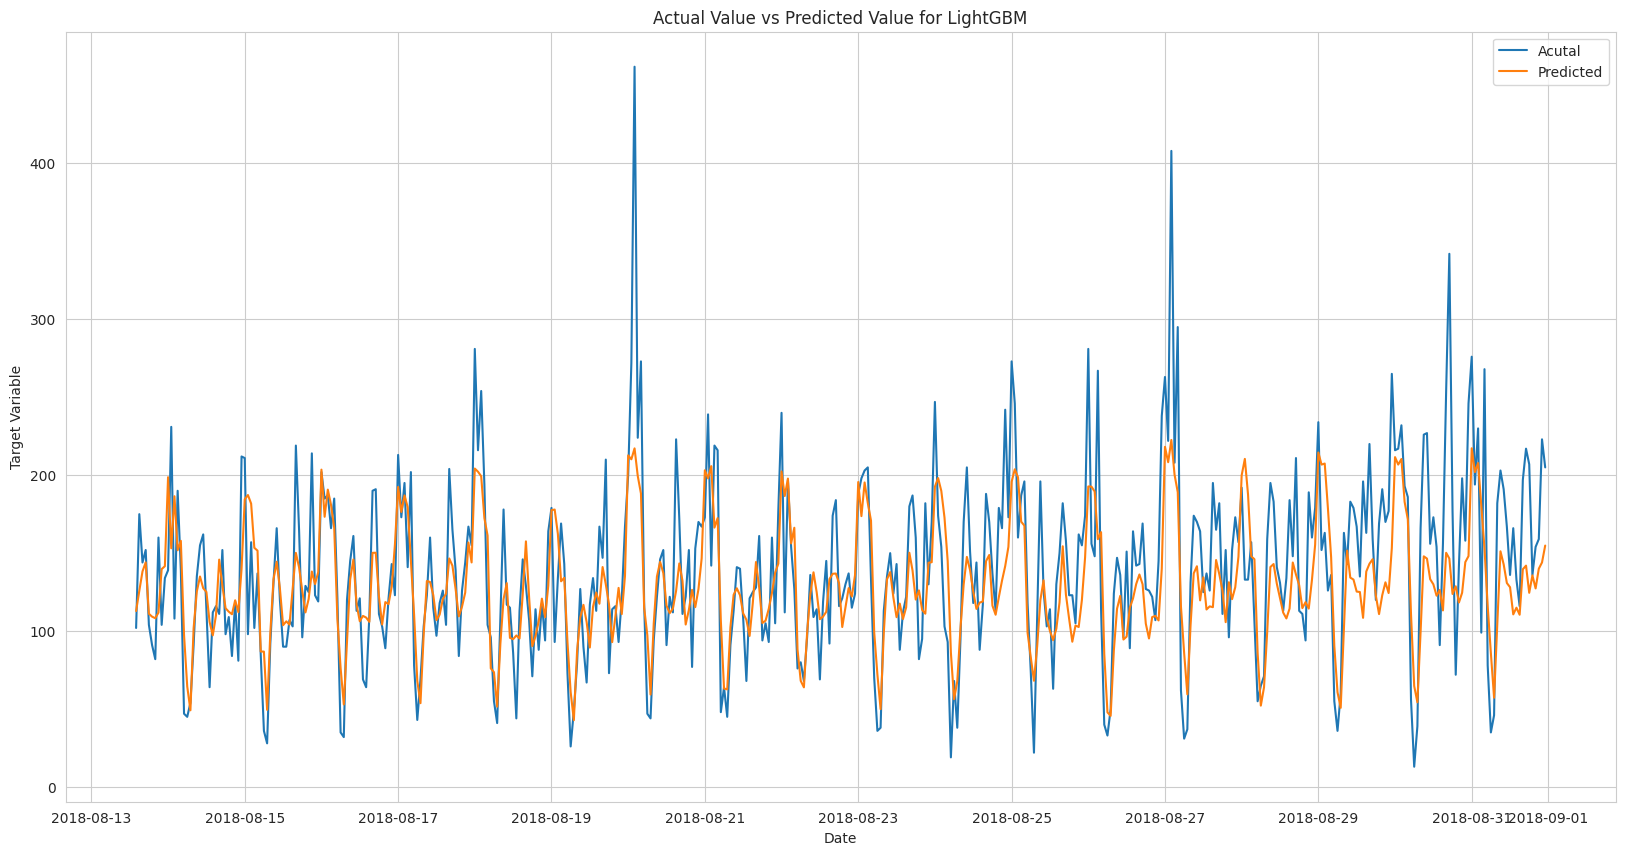

In [35]:
#Visual of Actual vs Predicted Values for LightGBM 

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(target_test.index, target_test, label='Acutal')
ax.plot(target_test.index,predictions_valid_lgbm, label='Predicted')
ax.set_title('Actual Value vs Predicted Value for LightGBM')
ax.set_xlabel('Date')
ax.set_ylabel('Target Variable')
ax.legend()

plt.show()

Conclusion: In examining the models devised it can be concluded that the LightGBM model provides the best predictive performance compared to the three models. The optimal LightGBM performance was 41.9. 

It is recommended that the Sweet Lift company use the LightGBM model to predict the number of taxi orders for the next hour. This should promote greater predictive accuracy and ensure customers are content. 